#  ResNet

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling2D
# Global pooling reduces the spatial dimensions of the data to a single value per feature map, Used for Expansion and Projection. For point wise conv
from keras.models import Model, load_model
# Activation introduces the non-linearity of the model
# ZeroPadding for controlling the Spatial Dimension
# Batch Normalization normalizes the activations of previous layer. It helps stabilize and speed up the training process 
from keras.preprocessing import image # loading and processing the image
# to download files from internet- get_files
from keras.utils import get_file # used to download the pre-trained models or datasets
# preprocessing on input images
from keras.applications.imagenet_utils import preprocess_input

# keras model to Graphviz DOR format representation. used to visualize the model architecture
from keras.utils import model_to_dot
# plot_model creates a visualization of a keras model using Graphviz
from keras.utils import plot_model

from resnets_utils import * # local utils for ResNet
# used to initialize the weights of neural network layers in a way that helps training stability
from keras.initializers import glorot_uniform
from keras.initializers import Initializer

import scipy.misc
from matplotlib.pyplot import imshow
import pydot # python interface to Graphviz graph visualization tool
from IPython.display import SVG # to display SVG (Scalable Vector Graphics)

from PIL import Image
import matplotlib.pyplot as plt

import pydot

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/home/jerlshin/env_ai/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


We do "Skip Connection"
We skip three hidden layers; Powerfull


CONV2D->BatchNorm->ReLu -> (same) -> (same)


In [10]:
def identity_block(X, f, filters, stage, block):
    # x - (m, n_H_prev, n_W_prev, n_C_prev)
    # f - (Integer, shape of middle CONV's windows for the main path)
    # filters - py list of int. no of filters in the CONV layers fo the main path
    # stage - integer. To name the layers, depending on their position in the network
    # block - string/character, used to name the layers, depending on their position in the network
    
    # Defining the name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X # save the input value
    
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X    

## The convolutional Block


In [11]:

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining the name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path 
    X = Conv2D(F2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    
    
    return X

## ResNet model

In [12]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    X_input = Input(input_shape)
    
    X  = ZeroPadding2D(padding=(3, 3))(X_input)
    
    ## Stage 1
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
    
    ## Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ## Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    ## Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    ## Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    ## Average pooling 
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc'+str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    
    # create a model
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
    
    return model

In [14]:
model = ResNet50(input_shape=(64, 64, 3), classes=6)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [19]:
model.fit(X_train, Y_train, epochs=2, batch_size=32)

Epoch 1/2
34/34 [==============================] - 28s 568ms/step - loss: 1.7697 - accuracy: 0.5037
Epoch 2/2
34/34 [==============================] - 21s 608ms/step - loss: 0.5818 - accuracy: 0.8102


In [20]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 112ms/step - loss: 3.9006 - accuracy: 0.1667
Loss = 3.9005768299102783
Test Accuracy = 0.1666666716337204


In [23]:
model = load_model('resnet50.h5') 

In [24]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 97ms/step - loss: 0.1596 - accuracy: 0.9500
Loss = 0.15958665311336517
Test Accuracy = 0.949999988079071


Input image shape: (1, 64, 64, 3)


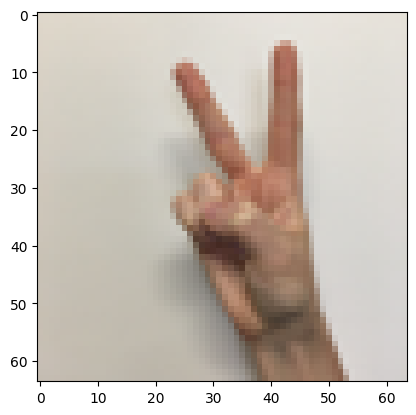

class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
1/1 [==============================] - 1s 526ms/step
[[1.4978890e-04 3.7133694e-02 8.9286065e-01 5.7792629e-04 6.9225319e-02
  5.2661446e-05]]


In [28]:

img_path = 'images/my_image.jpg'
img = Image.open(img_path)
img = img.resize((64, 64))  # Resize the image to the desired dimensions
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
print('Input image shape:', x.shape)

plt.imshow(img)
plt.show()

print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [30]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv2d_7[0][0]']     

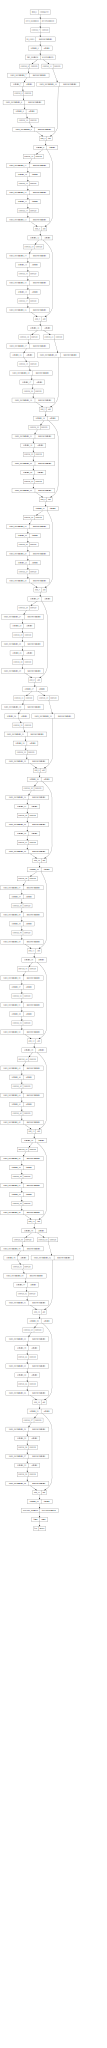

In [38]:
from IPython.display import SVG
import pydot

# Assuming you have a 'model' variable defined and loaded with your model

# Save model architecture to a file
plot_model(model, to_file='model.png')

# Display the model architecture as SVG
SVG(model_to_dot(model).create(prog='dot', format='svg'))
